<a href="https://colab.research.google.com/github/HarmanDotpy/Compressive_Sensing_Sparse_Signal/blob/master/5.StochProc_Kalman_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [0]:
import torch
import torch.nn as nn 
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt

Implementing the stochastic process

In [2]:
# Process vector is x and its size  is q * 1
# N sensors , k * 1 measurement is made by each sensor
q = 4
N = 5
k = 2

#helper matrices to generate process matrices
mat = torch.FloatTensor(q,q).uniform_(0,1)
Zq = 2 * torch.FloatTensor(q, q).uniform_(-1,1)
Zr =  0.1 * torch.FloatTensor(k * N, k * N).uniform_(-1,1)

#Initialize Constant process matrices
A = 0.5 * (mat/mat.sum(1).view(q,1)) #singly - stochastic - matrix * factor
C = torch.FloatTensor(k * N,q).uniform_(0,1)
Q = torch.mm(Zq, Zq.T)
R = torch.mm(Zr, Zr.T)
xo = torch.FloatTensor(q, 1).uniform_(0,1)

print('A = \n{} \n\nC = \n{} \n\nQ = \n{} \n\nR = \n{} \n\nxo = \n{}'.format(A, C, Q, R, xo))
print(A.sum(1))

A = 
tensor([[0.0692, 0.1502, 0.2152, 0.0654],
        [0.2007, 0.0862, 0.1479, 0.0652],
        [0.0490, 0.0776, 0.0648, 0.3086],
        [0.1572, 0.1188, 0.2125, 0.0116]]) 

C = 
tensor([[0.1486, 0.0811, 0.9229, 0.0301],
        [0.8851, 0.7558, 0.9808, 0.5575],
        [0.1237, 0.6267, 0.3660, 0.3884],
        [0.7765, 0.5847, 0.8816, 0.5950],
        [0.5294, 0.8280, 0.3364, 0.7158],
        [0.4664, 0.0288, 0.7439, 0.0323],
        [0.1561, 0.8623, 0.7037, 0.6381],
        [0.7224, 0.3282, 0.3174, 0.7237],
        [0.6696, 0.2341, 0.5881, 0.0430],
        [0.7416, 0.4700, 0.6154, 0.5833]]) 

Q = 
tensor([[ 6.1634, -3.2370, -2.4201,  3.0309],
        [-3.2370,  5.3367,  0.8184,  1.4746],
        [-2.4201,  0.8184,  5.5855, -0.5291],
        [ 3.0309,  1.4746, -0.5291,  7.6494]]) 

R = 
tensor([[ 3.2851e-02,  1.2697e-02,  3.8129e-03,  4.1202e-03, -2.6465e-03,
          2.8408e-02, -3.6550e-04, -4.5764e-03,  3.4316e-03, -1.5170e-02],
        [ 1.2697e-02,  3.3360e-02,  1.5723e-03,  6

In [0]:
# Generating the stochastiic process
x = [xo]
y = []
z = []
for i in range(10000):
  
  # with noise
  x.append(torch.mm(A, x[-1]) + MultivariateNormal(torch.zeros(q), Q).sample().view(q,1))
  y.append(torch.mm(C, x[-1]) + MultivariateNormal(torch.zeros(k * N), R).sample().view(k * N,1))
x = torch.stack(x)
y = torch.stack(y)


Visualizing the Process

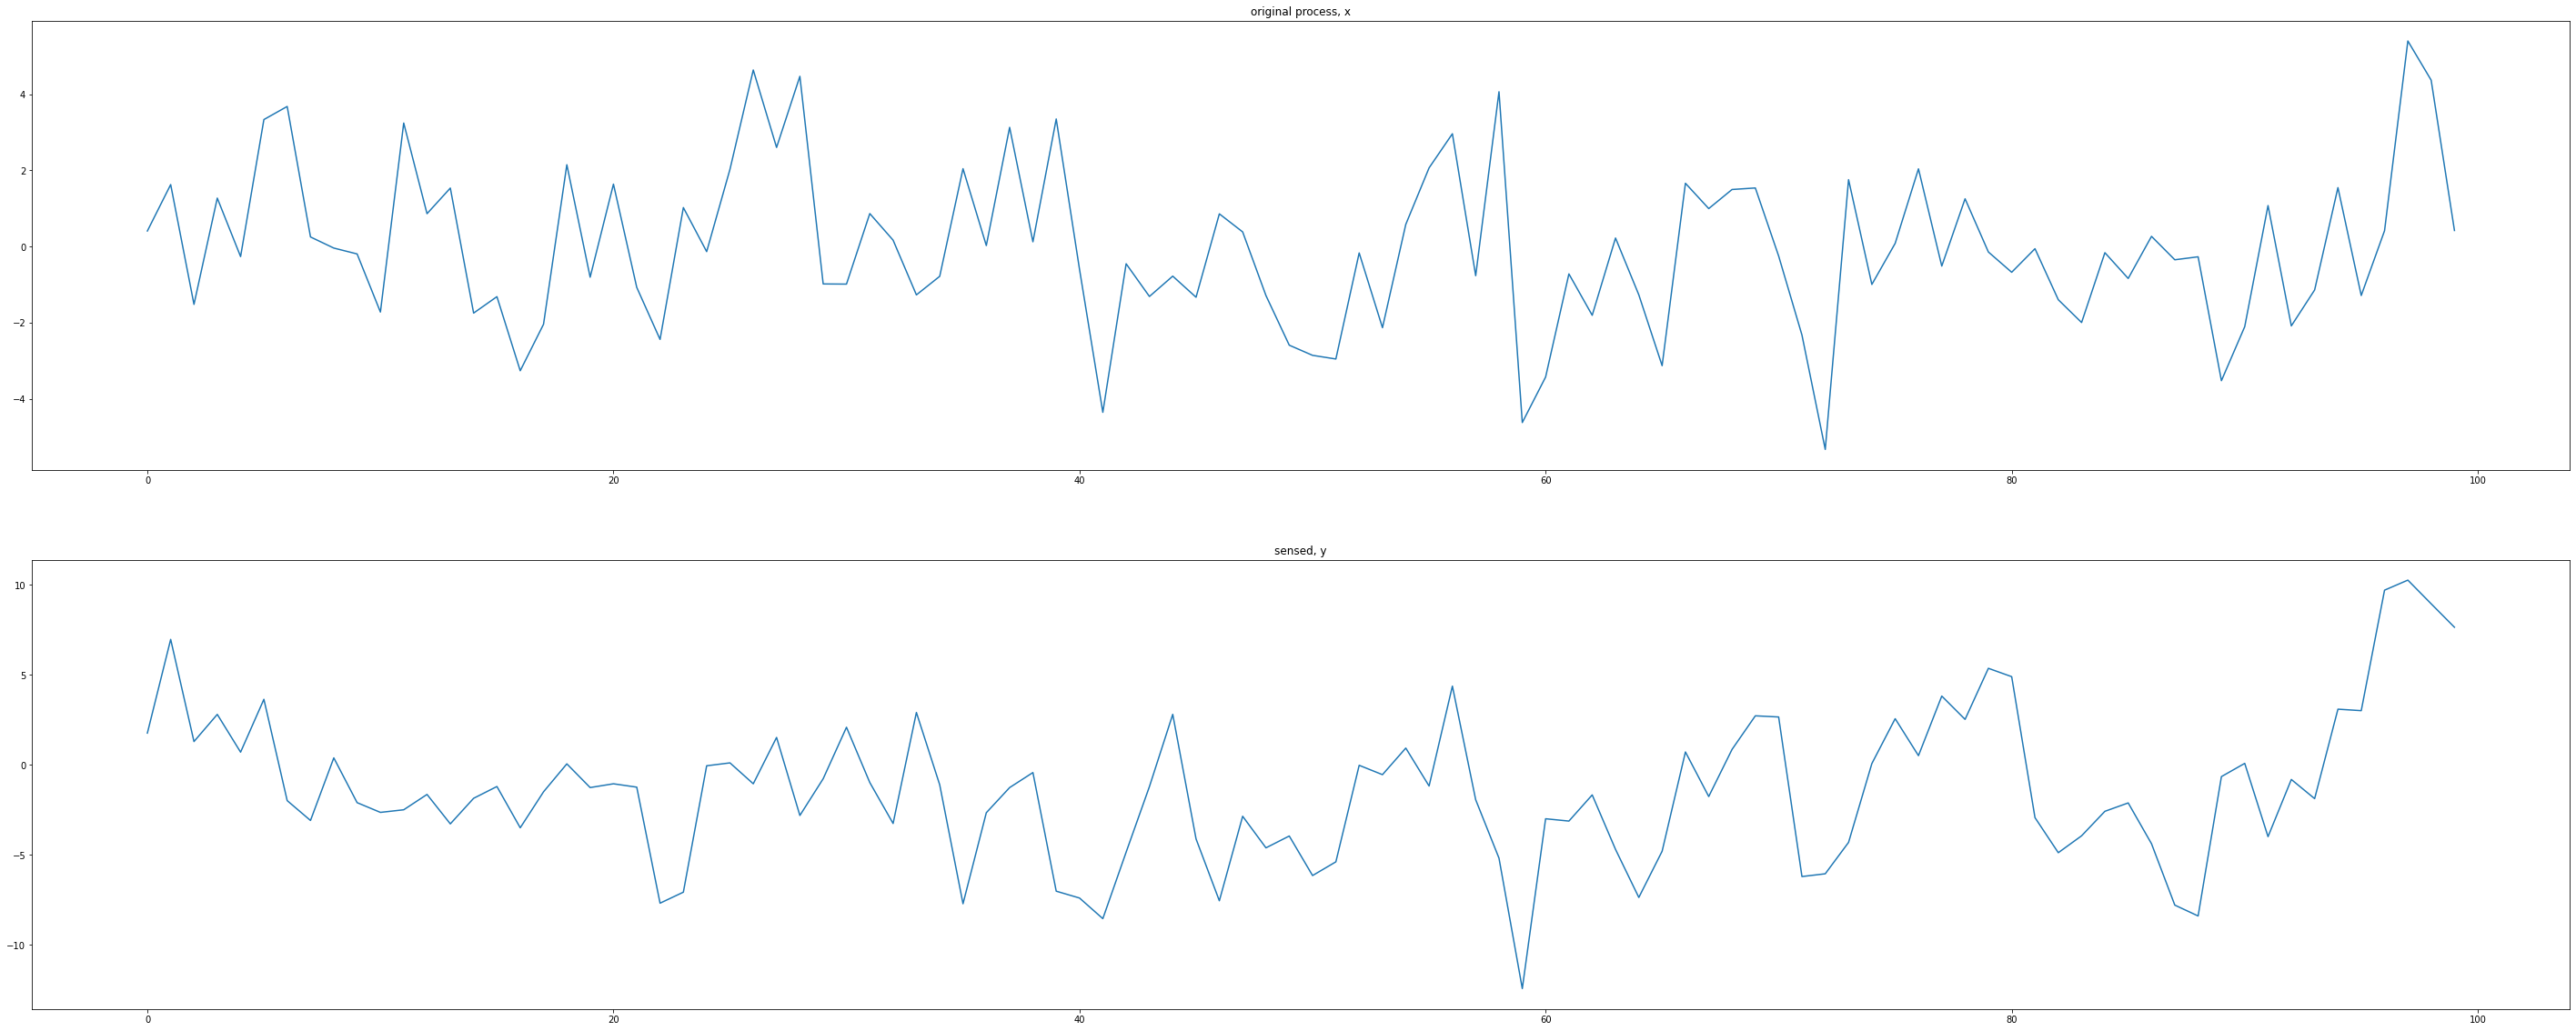

In [4]:
start, end = 0, 100
# x is q,1 and y is k*N,1 choose the indeces to visualize
x_index, y_index = 1,1
fig, axis = plt.subplots(2,1)
axis[0].plot(x[start:end,x_index])
axis[0].title.set_text('original process, x')
axis[1].plot(y[start:end,y_index])
axis[1].title.set_text('sensed, y')
fig.set_size_inches(w = 50, h = 20)
plt.show()

Coding and Fitting a Kalman Filter to X using Y.

In [0]:
def kalman(A, C, Q, R, y, process_size_q, xhat_prev, P_prev):
  '''
  prior means the prior estimate of the variable at current time For eg xhat_prior = xhat_k'
  prev means the value of the variable at the prev time instant For eg xhat_prev = xhat_k-1
  '''
  xhat_prior = torch.mm(A, xhat_prev)
  P_prior = torch.chain_matmul(A, P_prev, A.t()) + Q
  Sigma_z = torch.chain_matmul(C, P_prior, C.t()) + R
  K = torch.chain_matmul(P_prior, C.t(), torch.inverse(Sigma_z))

  # update values of estimate and the error covariance matrix at this instant
  xhat = xhat_prior + torch.mm(K, (y - torch.mm(C, xhat_prior)))
  P = torch.mm((torch.eye(process_size_q) - torch.mm(K, C)), P_prior)
  return xhat, P, Sigma_z

Using the kalman filter code to get the estimate of the process

In [0]:
# xhat = 0 and creating a PSD matrix P for initial step of the kalman filter
xhat = torch.zeros((q,1))
x_estimate = [xhat]
Zp = torch.FloatTensor(q,q).uniform_(-1,1)
P = torch.mm(Zp, Zp.t())
detector_values_true = []

for i in range(2000):
  # calculation of the innovation vector, z. This is being sent to the remote estimator
  zt = y[i] - torch.chain_matmul(C, A, xhat)
  # estimation of xhat and error covariance matrix using kalman filter.
  # It can be assumed that we are giving zt instead of y[i] to the kalman filter, just to keep consistency with what our system is doing
  xhat, P, Sigma_z = kalman(A, C, Q, R, y[i], q, xhat, P)
  x_estimate.append(xhat)
  # detector_values_true.append(torch.chain_matmul(zt.t(), torch.inverse(Sigma_z), zt).item())
  detector_values_true.append((zt.t() @ torch.inverse(Sigma_z) @ zt).item())

Visualizing the estimates and the original process

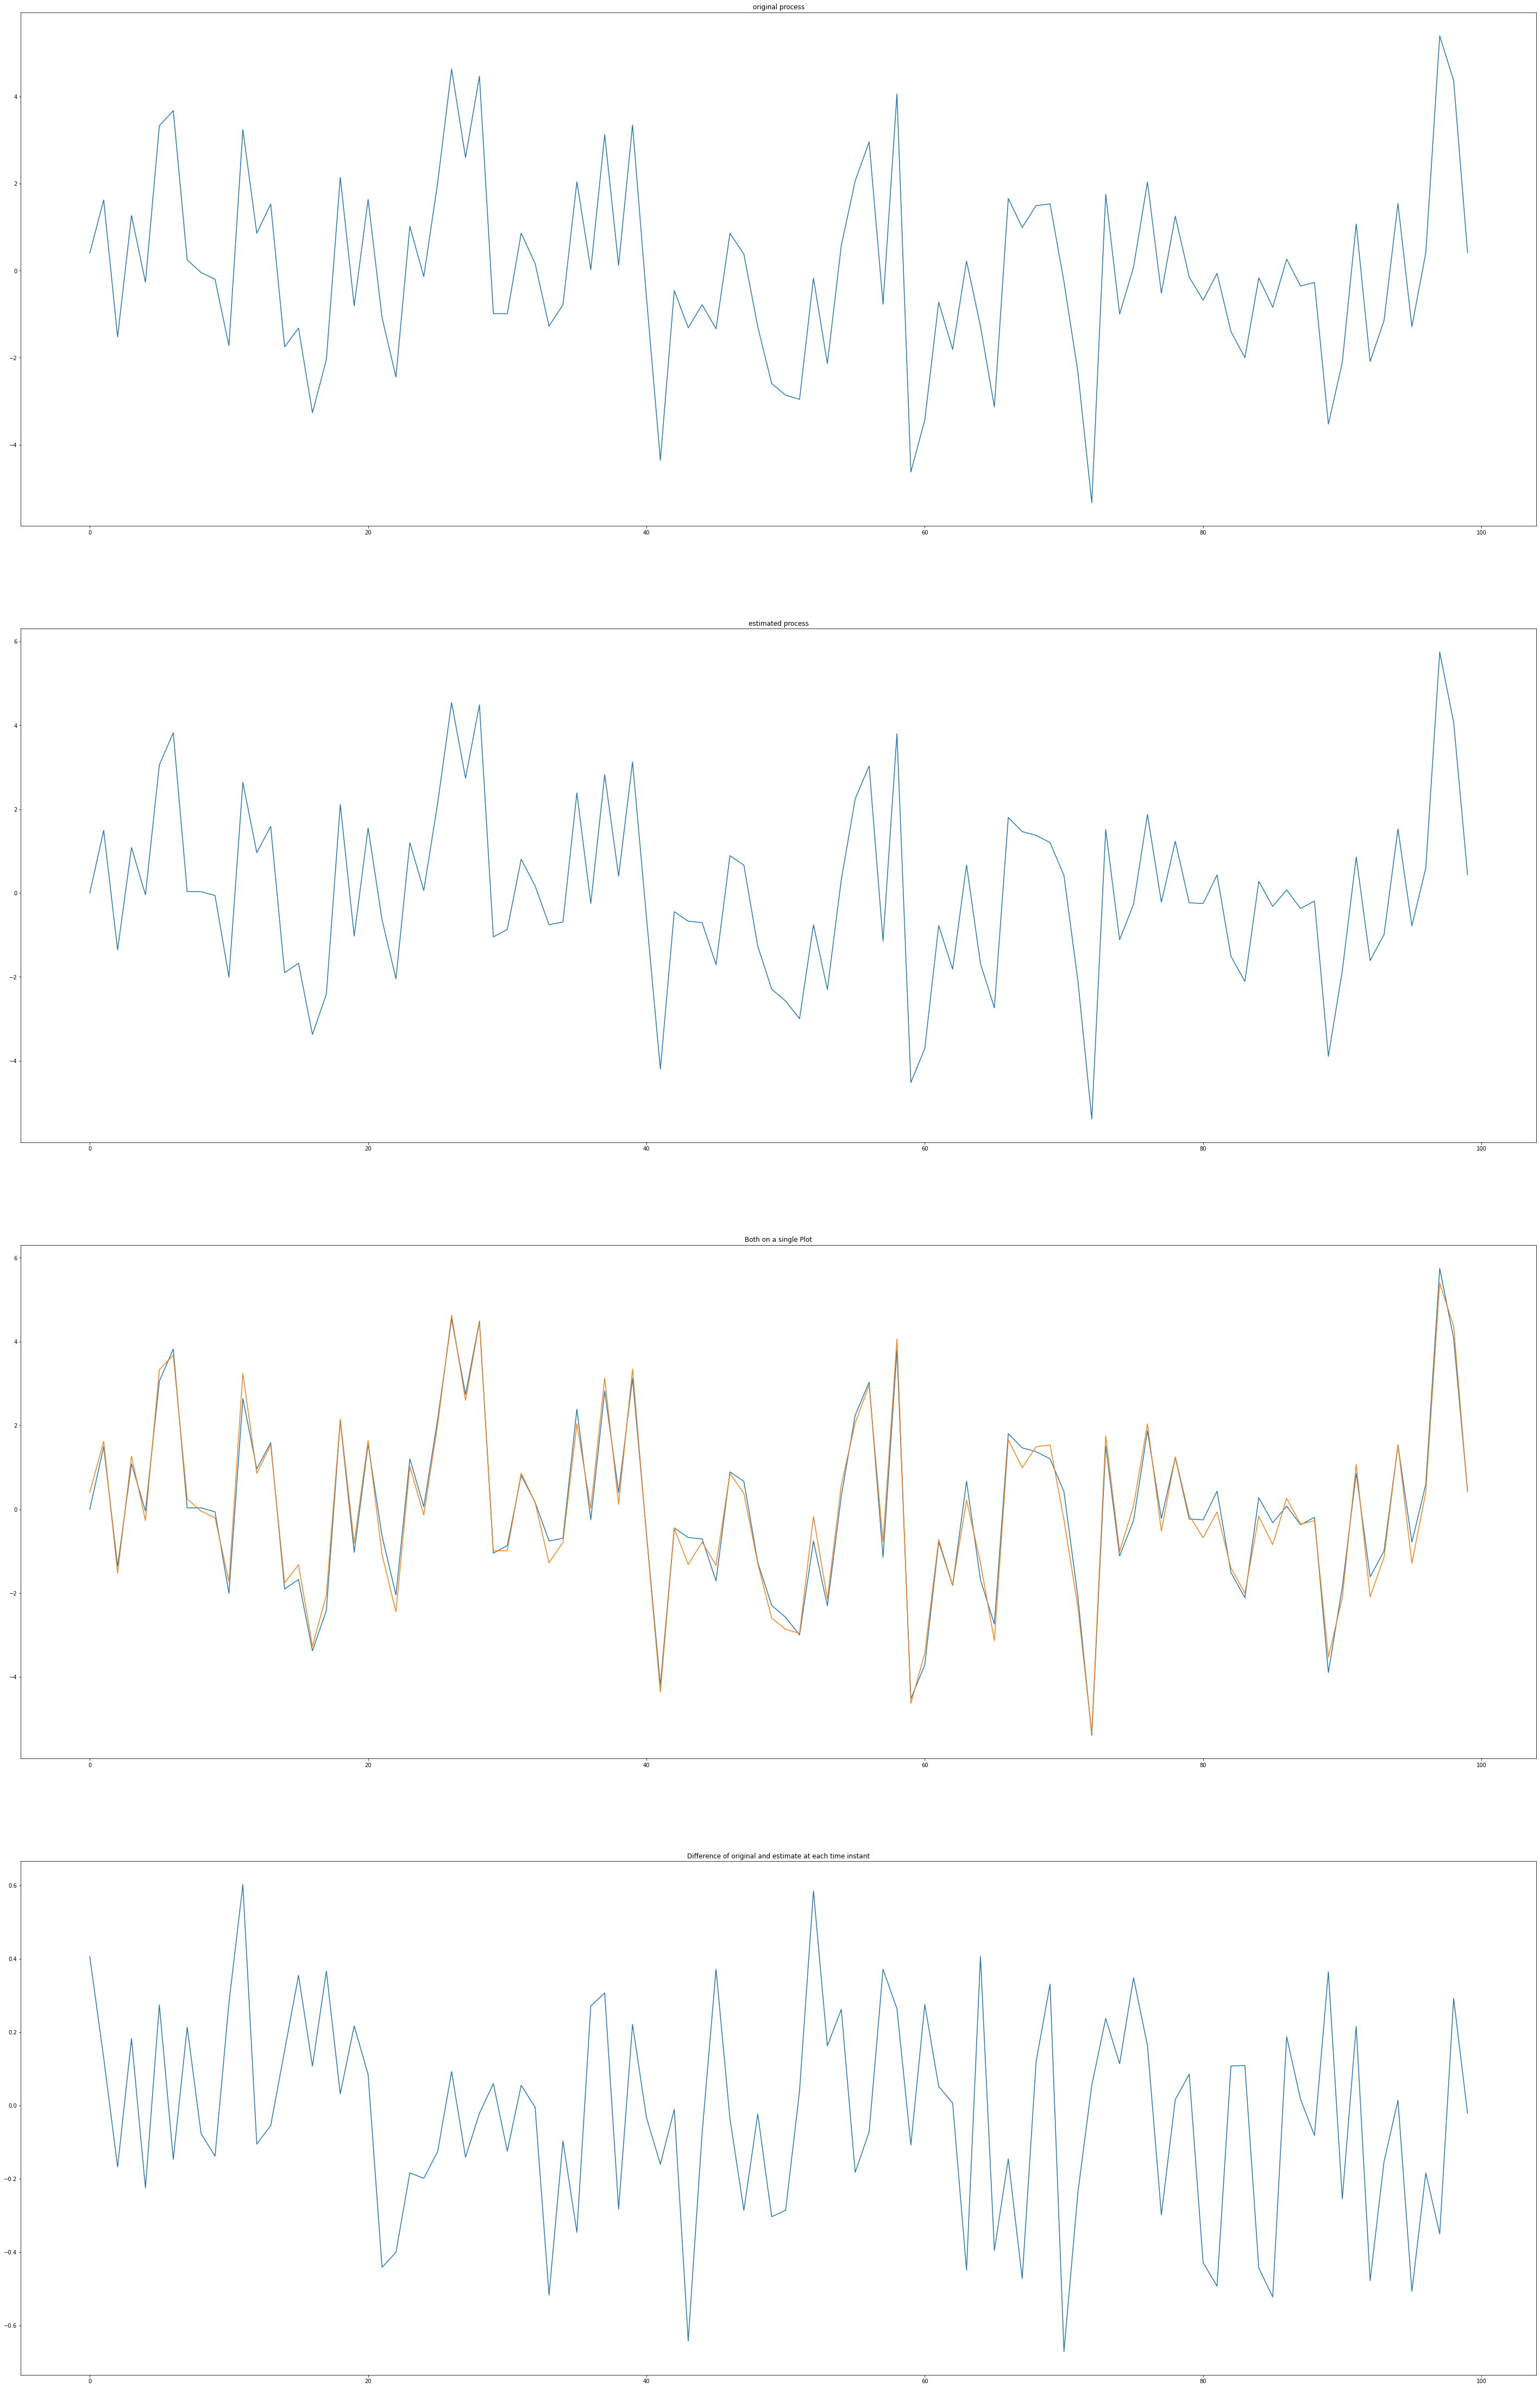

In [7]:
x_estimate = torch.stack(x_estimate)
# start, end - for visualizing till 'end''th time step starting from 'start' time
start, end = 0, 100
fig, axis = plt.subplots(4,1)
axis[0].plot(x[0:end, 1])
axis[0].title.set_text('original process')
axis[1].plot(x_estimate[0:end, 1])
axis[1].title.set_text('estimated process')
axis[2].plot(x_estimate[0:end,1])
axis[2].plot(x[0:end, 1])
axis[2].title.set_text('Both on a single Plot')
axis[3].plot(x[0:end,1] - x_estimate[0:end, 1])
axis[3].title.set_text('Difference of original and estimate at each time instant')
fig.set_size_inches(w = 50, h = 80)


Visualizing the chisquare detector value  = z.t * sigma_z * z

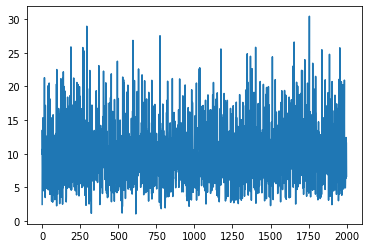

In [8]:
plt.plot(detector_values_true)
plt.show()